In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from mne.io import read_raw_fif
import matplotlib.pyplot as plt

%matplotlib inline

# Load in the data for the first framerate test, without triggers
ptb_data = pd.read_csv(Path("../data/240hz/framerate_test_fliptimes_ptb.csv"))
ptb_data = ptb_data - ptb_data.iloc[0]
logger_data = pd.read_pickle(Path("../data/240hz/framerate_flicker_test_logger.pkl"))
raw_data = read_raw_fif(
    Path("../data/240hz/berk_framerate_test_240hz_with_logger.fif"),
    preload=True,
    verbose="ERROR",
)

ptb_diffs = pd.DataFrame(np.diff(ptb_data.values.flatten()), columns=["flip_times"])
logger_diffs = pd.DataFrame(
    np.diff(logger_data["continuous"][1]["frame_flips"]), columns=["logger_times"]
)
alldiffs = ptb_diffs.join(logger_diffs)
meltdiffs = alldiffs.melt(value_name="times", var_name="source")
meltdiffs["freqs"] = 1 / meltdiffs["times"]

['MISC010', 'STI101', 'SYS201']


/var/folders/6x/cg6jvt750xl8q9tkh9t3fhfh0000gn/T/ipykernel_20850/1402176855.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  windows = np.arange(1.0, ptb_offset + 15, 0.2)


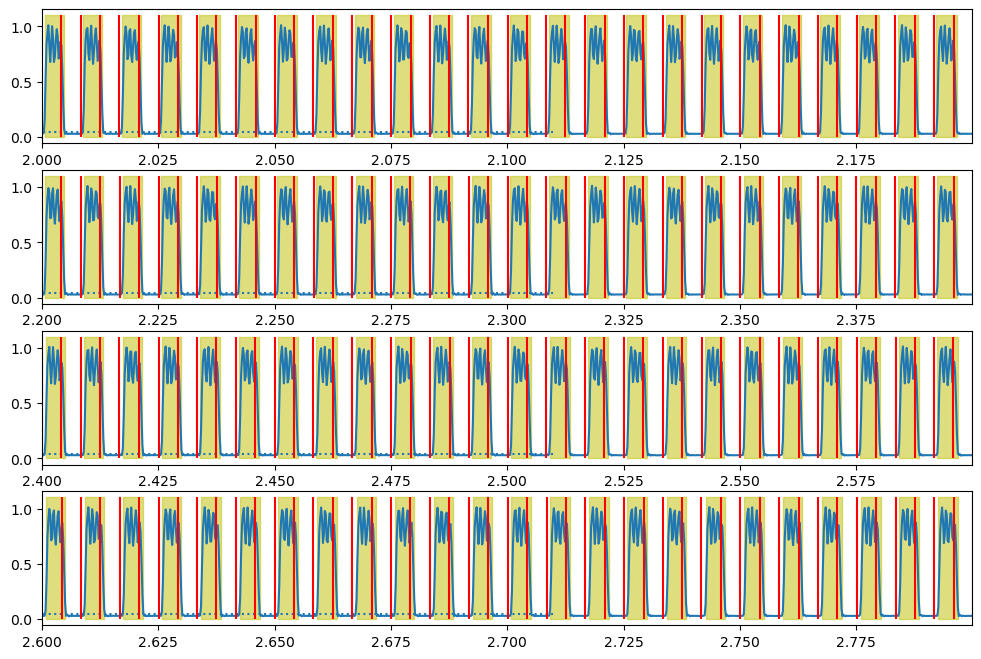

In [2]:
print(raw_data.ch_names)
off_thresh = 4.5e-2
photodiode, times = raw_data.get_data(["MISC010"], start=1 * 5000, return_times=True)
ons = (photodiode.T > off_thresh).flatten()
ptb_offset = times[np.argwhere(ons)[0]]
adj_ptb = ptb_data + ptb_offset
windows = np.arange(1.0, ptb_offset + 15, 0.2)
windows = np.vstack([windows[:-1], windows[1:]]).T
windows = windows[5:9]
fig, ax = plt.subplots(len(windows), figsize=(12, 2 * len(windows)))
i = 0
for min_t, max_t in windows:
    mask = (times < max_t) & (times >= min_t)
    ptb_mask = (adj_ptb < max_t) & (adj_ptb >= min_t)
    win_ons = (photodiode.T[mask] > off_thresh).flatten()
    ax[i].plot(times[mask], photodiode.T[mask])
    ax[i].hlines(off_thresh, ax[i].get_xlim()[0] - 0.1, ax[i].get_xlim()[1] - 0.1, ls=":")
    if ptb_mask.sum(axis=0).iloc[0] > 0:
        ax[i].vlines(adj_ptb[ptb_mask], 0, 1.1, color="r")
    ax[i].fill_between(
        times[mask],
        np.zeros(mask.sum()),
        np.ones(mask.sum()) * 1.1,
        where=win_ons,
        color="y",
        alpha=0.5,
    )
    ax[i].set_xlim(times[mask][0], times[mask][-1])
    i += 1


(7.15, 7.2248)

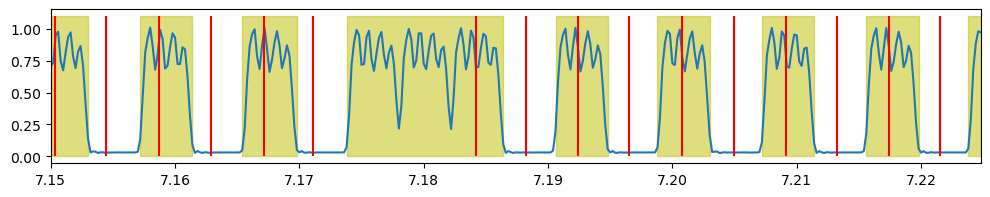

In [3]:
max_t = 7.225
min_t = 7.15
mask = (times < max_t) & (times >= min_t)
ptb_mask = (adj_ptb < max_t) & (adj_ptb >= min_t)
win_ons = (photodiode.T[mask] > off_thresh).flatten()
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(times[mask], photodiode.T[mask])
ax.hlines(off_thresh, ax.get_xlim()[0] - 0.1, ax.get_xlim()[1] - 0.1, ls=":")
if ptb_mask.sum(axis=0).iloc[0] > 0:
    ax.vlines(adj_ptb[ptb_mask], 0, 1.1, color="r")
ax.fill_between(
    times[mask],
    np.zeros(mask.sum()),
    np.ones(mask.sum()) * 1.1,
    where=win_ons,
    color="y",
    alpha=0.5,
)
ax.set_xlim(times[mask][0], times[mask][-1])

In [5]:
print((ptb_data).max())
print(ptb_mask.shape)
print(max(logger_data["continuous"][1]["frame_flips"]))
print(ptb_offset)
mask = (times >= ptb_offset) & (times < ptb_offset + 15)
flips = np.nonzero(np.diff(ons[mask].flatten()))
print(flips[0].shape)
photodiffs = pd.Series(np.diff(times[mask][flips]))
print((1 / photodiffs).describe())
print((1 / ptb_diffs).describe())
print(ptb_diffs.describe())


0    14.99649
dtype: float64
(3591, 1)
15.003725051879883
[1.0626]
(3586,)
count    3585.000000
mean      240.682861
std        16.284923
min        29.761905
25%       227.272727
50%       250.000000
75%       250.000000
max       263.157895
dtype: float64
        flip_times
count  3590.000000
mean    239.945620
std       9.259115
min      58.380714
25%     236.458676
50%     239.921290
75%     243.727352
max     574.011770
        flip_times
count  3590.000000
mean      0.004177
std       0.000325
min       0.001742
25%       0.004103
50%       0.004168
75%       0.004229
max       0.017129


(0.003, 0.005)

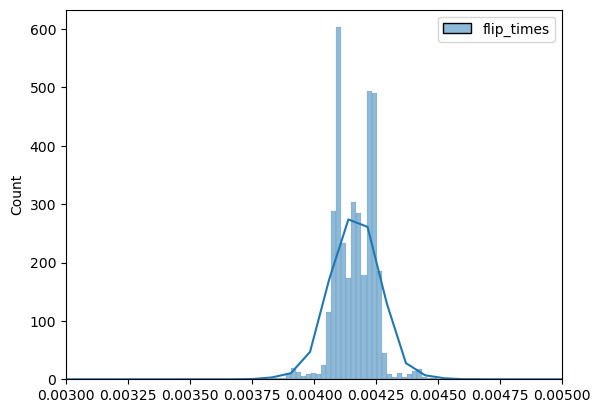

In [8]:
sns.histplot(ptb_diffs, bins=np.linspace(0.003, 0.005, 100), kde=True)
plt.xlim([0.003, 0.005])
